<a href="https://colab.research.google.com/github/afrojaakter/FallResearch2021/blob/main/VanillaRNN_classifier_trainLastStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import
import datetime
import h5py
import jax.numpy as np
from jax import grad, jit, lax, random, vmap
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import numpy as onp             # original CPU-backed NumPy
import os
import sys
import time
from importlib import reload
from functools import partial

In [ ]:
def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

####RNN

In [ ]:

"""Vanilla RNN functions for init, definition and running."""
MAX_SEED_INT = 10000000

def random_vrnn_params(key, u, n, o, g=1.0):
  """Generate random RNN parameters"""

  key, skeys = keygen(key, 4)
  hscale = 0.1
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  return {'h0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : random.normal(next(skeys), (n,n)) *  hfactor,
          'wO' : random.normal(next(skeys), (o,n)) * pfactor,
          'bR' : np.zeros([n]),
          'bO' : np.zeros([o])}


def affine(params, x):
  """Implement y = w x + b"""
  return np.dot(params['wO'], x) + params['bO']


# Affine expects n_W_m m_x_1, but passing in t_x_m (has txm dims) So
# map over first dimension to hand t_x_m.  I.e. if affine yields 
# n_y_1 = dot(n_W_m, m_x_1), then batch_affine yields t_y_n.  
batch_affine = vmap(affine, in_axes=(None, 0))


def vrnn(params, h, x):
  """Run the Vanilla RNN one step"""
  a = np.dot(params['wI'], x) + params['bR'] + np.dot(params['wR'], h)
  return np.tanh(a)


def vrnn_scan(params, h, x):
  """Run the Vanilla RNN one step, returning (h ,h)."""  
  h = vrnn(params, h, x)
  return h, h


def vrnn_run_with_h0(params, x_t, h0):
  """Run the Vanilla RNN T steps, where T is shape[0] of input."""
  f = partial(vrnn_scan, params)
  _, h_t = lax.scan(f, h0, x_t)
  o_t = batch_affine(params, h_t)
  return h_t, o_t


def vrnn_run(params, x_t):
  """Run the Vanilla RNN T steps, where T is shape[0] of input."""
  return vrnn_run_with_h0(params, x_t, params['h0'])

# Let's upgrade it to handle batches using `vmap`
# Make a batched version of the `predict` function
batched_rnn_run = vmap(vrnn_run, in_axes=(None, 0))
batched_rnn_run_w_h0 = vmap(vrnn_run_with_h0, in_axes=(None, 0, 0))
  
  
def loss(params, inputs_bxtxu, targets_bxtxo, targets_mask_t, l2reg):
  """Compute the least squares loss of the output, plus L2 regularization."""
  _, outs_bxtxo = batched_rnn_run(params, inputs_bxtxu)
  l2_loss = l2reg * optimizers.l2_norm(params)**2
  outs_bxsxo = outs_bxtxo[:, targets_mask_t, :]
  targets_bxsxo = targets_bxtxo[:, targets_mask_t, :]
  lms_loss = np.mean((outs_bxtxo - targets_bxtxo)**2)
  total_loss = lms_loss + l2_loss
  return {'total' : total_loss, 'lms' : lms_loss, 'l2' : l2_loss}


def update_w_gc(i, opt_state, opt_update, get_params, x_bxt, f_bxt,
                f_mask_bxt, max_grad_norm, l2reg):
  """Update the parameters w/ gradient clipped, gradient descent updates."""
  params = get_params(opt_state)

  def training_loss(params, x_bxt, f_bxt, l2reg):
    return loss(params, x_bxt, f_bxt, f_mask_bxt, l2reg)['total']
  
  grads = grad(training_loss)(params, x_bxt, f_bxt, l2reg)
  clipped_grads = optimizers.clip_grads(grads, max_grad_norm)
  return opt_update(i, clipped_grads, opt_state)


loss_jit = jit(loss)
update_w_gc_jit = jit(update_w_gc, static_argnums=(2,3))


def run_trials(batched_run_fun, inputs_targets_h0s_fun, nbatches, batch_size):
  """Run a bunch of trials and save everything in a dictionary."""
  inputs = []
  hiddens = []
  outputs = []
  targets = []
  h0s = []
  for n in range(nbatches):
    data_seeds = onp.random.randint(0, MAX_SEED_INT, size=batch_size)
    keys = np.array([random.PRNGKey(ds) for ds in data_seeds])
    input_b, target_b,  masks_b, h0s_b = inputs_targets_h0s_fun(keys)
    if h0s_b is None:
      h_b, o_b = batched_run_fun(input_b)
    else:
      h_b, o_b = batched_run_fun(input_b, h0s_b)      
      h0s.append(h0s_b)
      
    inputs.append(input_b)
    hiddens.append(h_b)
    outputs.append(o_b)
    targets.append(target_b)
    
  trial_dict = {'inputs' : onp.vstack(inputs), 'hiddens' : onp.vstack(hiddens),
                'outputs' : onp.vstack(outputs), 'targets' : onp.vstack(targets)}
  if h0s_b is not None:
    trial_dict['h0s'] = onp.vstack(h0s)
  else:
    trial_dict['h0s'] = None
  return trial_dict

def plot_params(params):
  """ Plot the parameters of the vanilla RNN. """
  plt.figure(figsize=(16,8))
  plt.subplot(231)
  plt.stem(params['wO'][0,:])
  plt.title('wO - output weights')
  
  plt.subplot(232)
  plt.stem(params['h0'])
  plt.title('h0 - initial hidden state')
  
  plt.subplot(233)
  plt.imshow(params['wR'], interpolation=None)
  plt.title('wR - recurrent weights')
  plt.colorbar()
  
  plt.subplot(234)
  plt.stem(params['wI'])
  plt.title('wI - input weights')
  
  plt.subplot(235)
  plt.stem(params['bR'])
  plt.title('bR - recurrent biases')
  '''
  plt.subplot(236)
  evals, _ = onp.linalg.eig(params['wR'])
  x = onp.linspace(-1, 1, 1000)
  plt.plot(x, onp.sqrt(1-x**2), 'k')
  plt.plot(x, -onp.sqrt(1-x**2), 'k')
  plt.plot(onp.real(evals), onp.imag(evals), '.')
  plt.axis('equal')
  plt.title('Eigenvalues of wR')
  '''
  
def plot_examples(ntimesteps, rnn_internals, nexamples=1):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(nexamples*5, 12))
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, bidx+1)
    plt.plot(rnn_internals['inputs'][bidx,:], 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Input')
      
  ntoplot = 10
  closeness = 0.25
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, nexamples+bidx+1)
    plt.plot(rnn_internals['hiddens'][bidx, :, 0:ntoplot] +
             closeness * onp.arange(ntoplot), 'b')
    plt.xlim([0, ntimesteps])
    if bidx == 0:
      plt.ylabel('Hidden Units')
      
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, 2*nexamples+bidx+1)
    plt.plot(rnn_internals['outputs'][bidx,:,:], 'r', label = 'Outputs')
    plt.plot(rnn_internals['targets'][bidx,:,:], 'k', label = 'targets')    
    plt.xlim([0, ntimesteps])
    plt.xlabel('Timesteps')
    if bidx == 0:
      plt.ylabel('Output')
    plt.legend()

####Integrator

In [ ]:
def build_input_and_target_binary_decision(input_params, key):
  """Build white noise input and decision targets.
  The decision is whether the white noise input has a perfect integral
  greater than, or less than, 0. Output a +1 or -1, respectively.
  Arguments: 
    inputs_params: tuple of parameters for this decision task
    key: jax random key for making randomness
  Returns:
    3-tuple of inputs, targets, and the target mask, indicating 
      which time points have optimization pressure on them"""
  
  bias_val, stddev_val, T, ntime = input_params
  dt = T/ntime

  # Create the white noise input.
  key, skeys = keygen(key, 2)
  random_sample = random.normal(next(skeys), (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / np.sqrt(dt)
  random_samples = random.normal(next(skeys), (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t

  # * dt, intentionally left off to get output scaling in O(1).
  pure_integration_t = np.cumsum(white_noise_t)
  #print('pure', pure_integration_t[-1])
  decision = 2.0*((pure_integration_t[-1] > 0.0)-0.5)
  targets_t = np.zeros(pure_integration_t.shape[0]-1)
  targets_t = np.concatenate([targets_t,
                              np.array([decision], dtype=float)], axis=0)
  inputs_tx1 = np.expand_dims(white_noise_t, axis=1)
  targets_tx1 = np.expand_dims(targets_t, axis=1)
  target_mask = np.array([ntime-1]) # When target is defined.
  #print('targetMstk', target_mask)
  return inputs_tx1, targets_tx1, target_mask

# Now batch it and jit.
build_input_and_target = build_input_and_target_binary_decision
build_inputs_and_targets = vmap(build_input_and_target, in_axes=(None, 0))
build_inputs_and_targets_jit = jit(build_inputs_and_targets,
                                   static_argnums=(0,))

def plot_batch(input_params, input_bxtxu, target_bxtxo=None, output_bxtxo=None,
               errors_bxtxo=None, ntoplot=1):
  """Plot some white noise / integrated white noise examples."""
  bval, sval, T, ntimesteps = input_params
  plt.figure(figsize=(16,12))
  plt.subplot(311)
  xs = np.arange(1, ntimesteps+1)
  plt.plot(xs, input_bxtxu[0:ntoplot,:,0].T)
  plt.xlim([1, ntimesteps])
  plt.ylabel('Noise')
  plt.subplot(312)
  if output_bxtxo is not None:
    plt.plot(xs, output_bxtxo[0:ntoplot,:,0].T);
    plt.xlim([1, ntimesteps]);
  if target_bxtxo is not None:
    plt.stem([ntimesteps]*ntoplot, target_bxtxo[0:ntoplot,ntimesteps-1,0].T, 'o');
    plt.xlim([1, ntimesteps+1]);
    plt.ylabel("Decision")
  plt.xlabel('Timesteps')

Hyperparameters

In [ ]:
# Integration parameters
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 25  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

# Integrator RNN hyperparameters
u = 1         # Number of inputs to the RNN
n = 100       # Number of units in the RNN
o = 1         # Number of outputs in the RNN

# The scaling of the recurrent parameters in an RNN really matters. 
# The correct scaling is 1/sqrt(number of recurrent inputs), which 
# yields an order 1 signal output to a neuron if the input is order 1.
# Given that VRNN uses a tanh nonlinearity, with min and max output 
# values of -1 and 1, this works out.  The scaling just below 1 
# (0.95) is because we know we are making a line attractor so, we 
# might as well start it off basically right 1.0 is also basically 
# right, but perhaps will lead to crazier dynamics.
param_scale = 0.85 # Scaling of the recurrent weight matrix

# Optimization hyperparameters
num_batchs = 10000         # Total number of batches to train on.
batch_size = 128          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.025          # initial learning rate
decay_factor = 0.99975     # decay the learning rate this much
# Gradient clipping is HUGELY important for training RNNs
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.0002           # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 100          # Print training informatino every so often

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


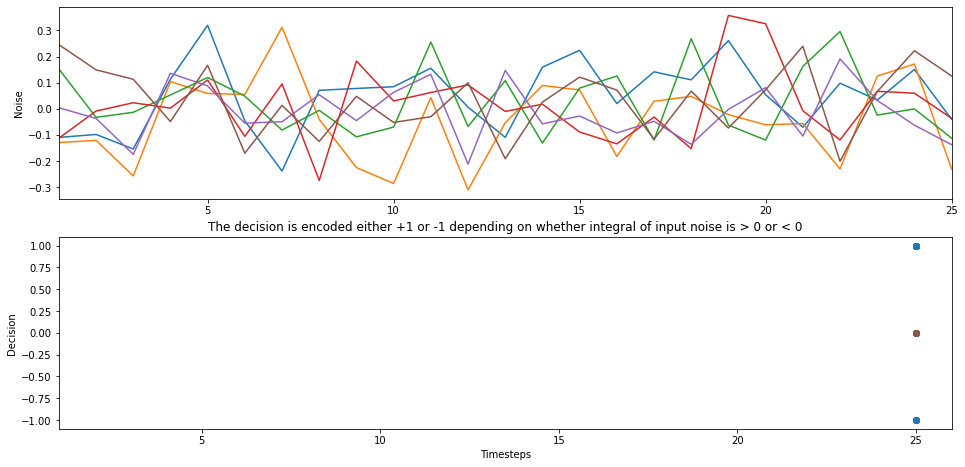

In [ ]:
# JAX handles randomness differently than numpy or matlab. 
# one threads the randomness through to each function. 
#  It's a bit tedious, but very easy to understand and with
# reliable effect.
seed = 476125
key = random.PRNGKey(seed)
# Plot a few input/target examples to make sure things look sane.
ntoplot = 6    # how many examples to plot
# With this split command, we are always getting a new key from the old key,
# and I use first key as as source of randomness for new keys.
#     key, subkey = random.split(key, 2)
#     ## do something random with subkey
#     key, subkey = random.split(key, 2)
#     ## do something random with subkey
# In this way, the same top level randomness source stays random.

# The number of examples to plot is given by the number of 
# random keys in this function.
key, skey = random.split(key, 2)
skeys = random.split(skey, ntoplot) # get ntoplot random keys
inputs, targets, _ = build_inputs_and_targets_jit(input_params, skeys)

# Plot the input to the RNN and the target for the RNN.
plot_batch(input_params, inputs, targets, ntoplot=ntoplot)
plt.title('The decision is encoded either +1 or -1 depending \
on whether integral of input noise is > 0 or < 0');

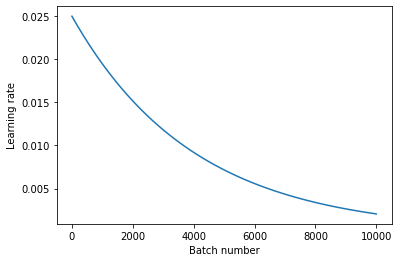

In [ ]:
# Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(step_size, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = onp.linspace(1, num_batchs)
plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warni

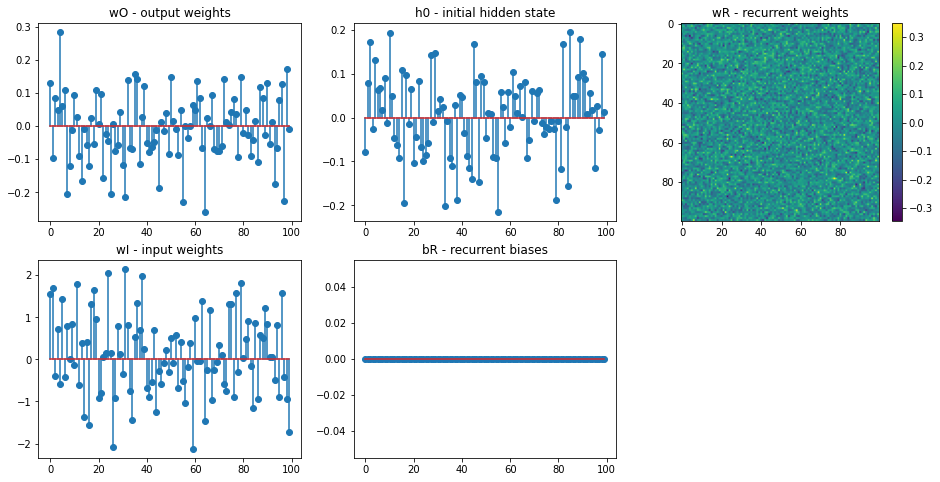

In [ ]:
# Init some parameters for training.
key, subkey = random.split(key, 2)
init_params = random_vrnn_params(subkey, u, n, o, g=param_scale)
plot_params(init_params)

In [ ]:
# Initialize the optimizer.  Please see jax/experimental/optimizers.py
opt_init, opt_update, get_params = optimizers.adam(decay_fun, adam_b1, adam_b2, adam_eps)
opt_state = opt_init(init_params)

# Run the optimization loop, first jit'd call will take a minute.
start_time = time.time()
all_train_losses = []
for batch in range(num_batchs):
    key, subkey = random.split(key, 2)
    skeys = random.split(subkey, batch_size)
    inputs, targets, target_masks = build_inputs_and_targets_jit(input_params, skeys)
    opt_state = update_w_gc_jit(batch, opt_state, opt_update, get_params, inputs,
                                  targets,target_masks, max_grad_norm, l2reg)
    if batch % print_every == 0:
        params = get_params(opt_state)
        all_train_losses.append(loss_jit(params, inputs, targets,target_masks, l2reg))
        train_loss = all_train_losses[-1]['total']
        batch_time = time.time() - start_time
        step_size = decay_fun(batch)
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
        print(s.format(batch, batch_time, step_size, train_loss))
        start_time = time.time()
        
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Batch 0 in 4.64 sec, step size: 0.02500, training loss 0.0890
Batch 100 in 0.71 sec, step size: 0.02438, training loss 0.0713
Batch 200 in 0.64 sec, step size: 0.02378, training loss 0.0693
Batch 300 in 0.61 sec, step size: 0.02319, training loss 0.0679
Batch 400 in 0.61 sec, step size: 0.02262, training loss 0.0666
Batch 500 in 0.61 sec, step size: 0.02206, training loss 0.0657
Batch 600 in 0.62 sec, step size: 0.02152, training loss 0.0641
Batch 700 in 0.62 sec, step size: 0.02099, training loss 0.0650
Batch 800 in 0.60 sec, step size: 0.02047, training loss 0.0642
Batch 900 in 0.61 sec, step size: 0.01996, training loss 0.0637
Batch 1000 in 0.61 sec, step size: 0.01947, training loss 0.0610
Batch 1100 in 0.62 sec, step size: 0.01899, training loss 0.0583
Batch 1200 in 0.61 sec, step size: 0.01852, training loss 0.0568
Batch 1300 in 0.61 sec, step size: 0.01806, training loss 0.0485
Batch 1400 in 0.61 sec, step size: 0.01762, training loss 0.0461
Batch 1500 in 0.61 sec, step size: 0.

Testing

In [ ]:
# Take a batch for an evalulation loss, notice the L2 penalty is 0
# for the evaluation.
params = get_params(opt_state)

key, subkey = random.split(key, 2)
skeys = random.split(subkey, batch_size)
inputs, targets, target_masks = build_inputs_and_targets_jit(input_params, skeys)
eval_loss = loss_jit(params, inputs, targets, target_masks, l2reg=0.0)['total']
eval_loss_str = "{:.5f}".format(eval_loss)
print("Loss on a new large batch: %s" % (eval_loss_str))

Loss on a new large batch: 0.00612


Visualizations of trained system

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


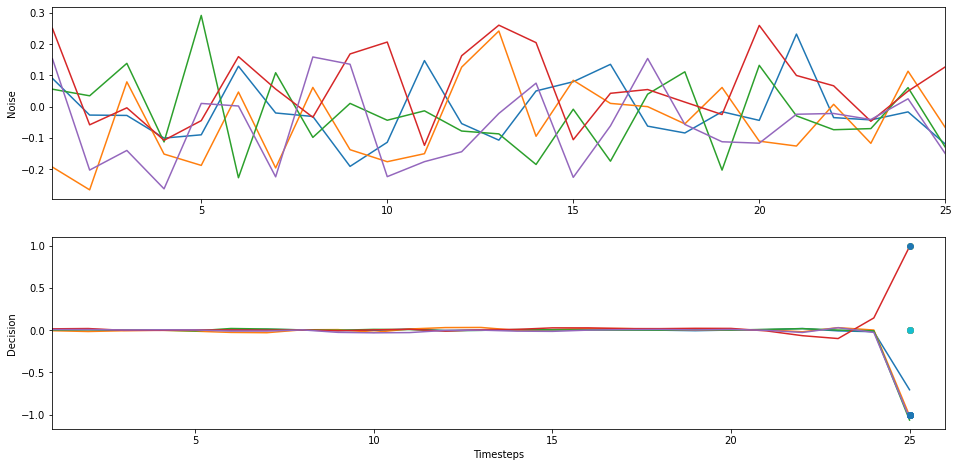

In [ ]:

# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = build_inputs_and_targets_jit(input_params, keys)
    h0s_b = None # Use trained h0
    masks_b = None #Not used
    return inputs_b, targets_b, masks_b, h0s_b

rnn_run = lambda inputs: batched_rnn_run(params, inputs)
give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

T = 1.0         # Arbitraty amount time, roughtly physiological
ntimesteps = 25
input_params = (bval, sval, T, ntimesteps)
nexamples = 40

rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)

plot_batch(input_params, rnn_internals['inputs'], 
          rnn_internals['targets'], rnn_internals['outputs'], 
          onp.abs(rnn_internals['targets'] - rnn_internals['outputs']), ntoplot = 5)

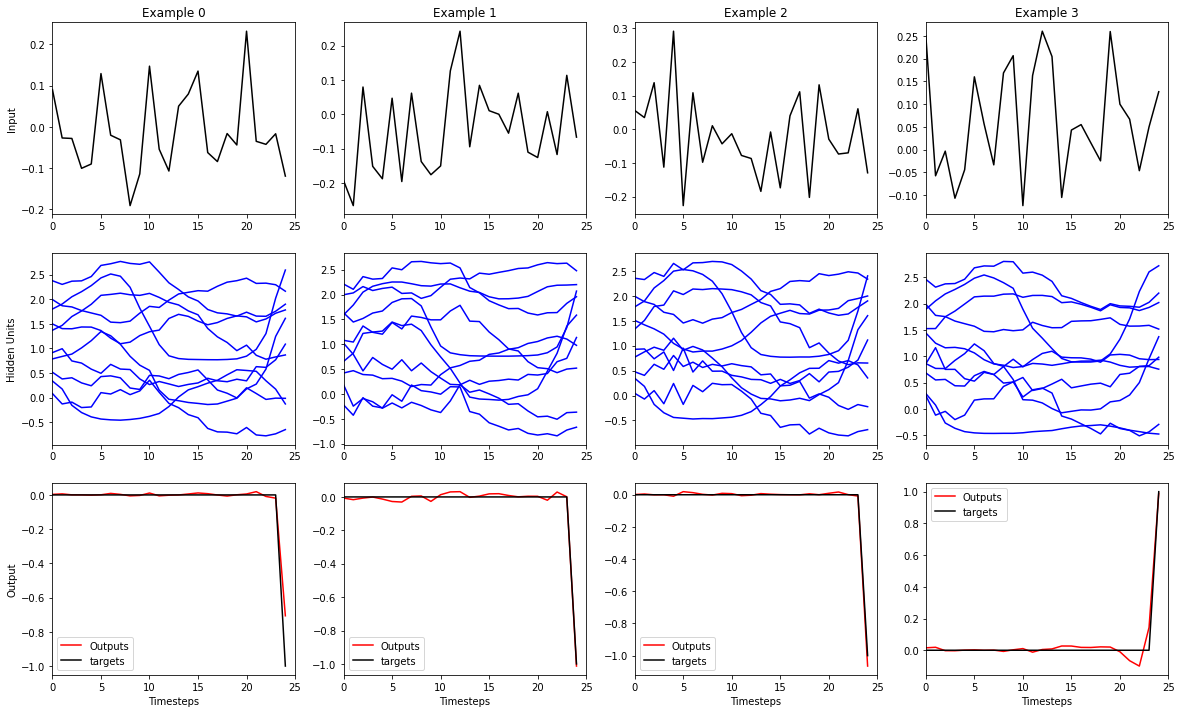

In [ ]:
# Visualize the hidden state, as an example.
plot_examples(ntimesteps, rnn_internals, nexamples=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warni

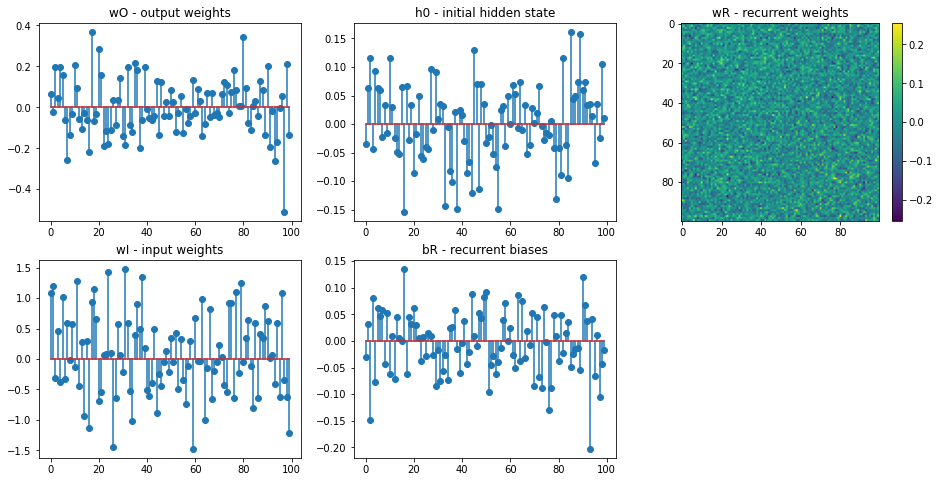

In [ ]:
# Take a look at the trained parameters.
plot_params(params)

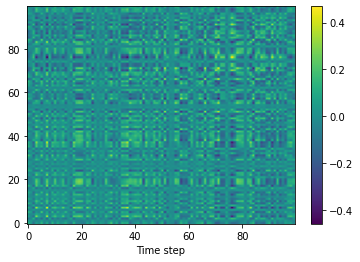

In [ ]:
x = rnn_internals['hiddens'][0] # params['wR']
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

Mu = onp.mean(x, axis=0)
z = x-Mu
Q = np.dot(z.T, z)/len(x) #Covariance matrix

fig = plt.figure()
ax = fig.add_subplot()
heatmap = ax.imshow(Q, origin = 'lower', aspect= 'auto')
ax.set_xlabel('Time step')
#ax.set_ylabel('Temperature')
cbar = fig.colorbar(heatmap) 
#cbar.set_label('$p_T(x)$',size=10)
plt.show()

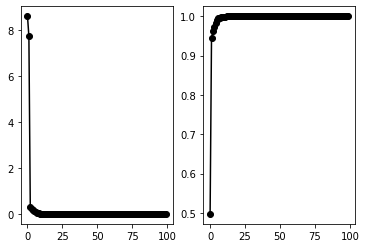

In [ ]:
F, V = onp.linalg.eig(Q)
Var = onp.flip(onp.sum(V, axis = 1))
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
ax1.plot(F,'-o',color='k')
ax2 = fig1.add_subplot(122)
ax2.plot(np.cumsum(F)/np.sum(F),'-o',color='k')
plt.show()

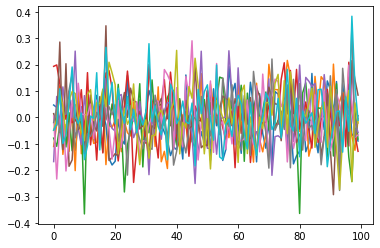

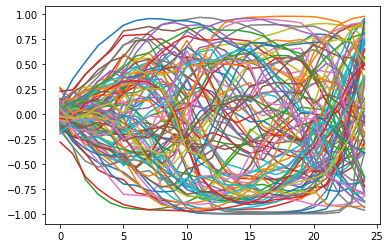

In [ ]:
for i in range(10):
  plt.plot(V[:, i])
plt.show()
plt.plot(x)
plt.show()

#Predicting in future time steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


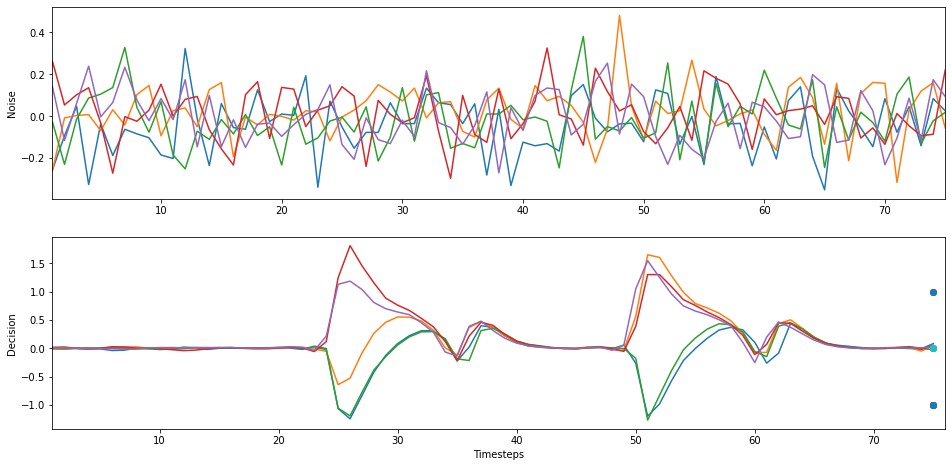

In [ ]:
#predicting in the future
# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        build_inputs_and_targets_jit(input_params, keys)
    h0s_b = None # Use trained h0
    masks_b = None # Not used
    return inputs_b, targets_b, masks_b, h0s_b

# rnn.batched_rnn_run = vmap(gru_run, in_axes=(None, 0)) handles batches using vmap
# jax.vmap, which is a transformation which automatically “vectorizes” a function.
rnn_run = lambda inputs: batched_rnn_run(params, inputs)
give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

T = 3.0         # Arbitraty amount time, roughtly physiological
ntimesteps = 75
input_params = (bval, sval, T, ntimesteps)

nexamples = 400
# rnn.trials: Run a bunch of trials and save everything in a dictionary:
# inputs, hiddens, outputs and targets, each an np array with dim
# nbatches*batch_size * ntimesteps * dim
rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)

error = onp.abs(rnn_internals['targets'] - rnn_internals['outputs'])

#Plot some white noise / integrated white noise examples
plot_batch(input_params, rnn_internals['inputs'], 
                    rnn_internals['targets'], rnn_internals['outputs'], 
                    onp.abs(rnn_internals['targets'] - rnn_internals['outputs']), 
                    ntoplot=5)


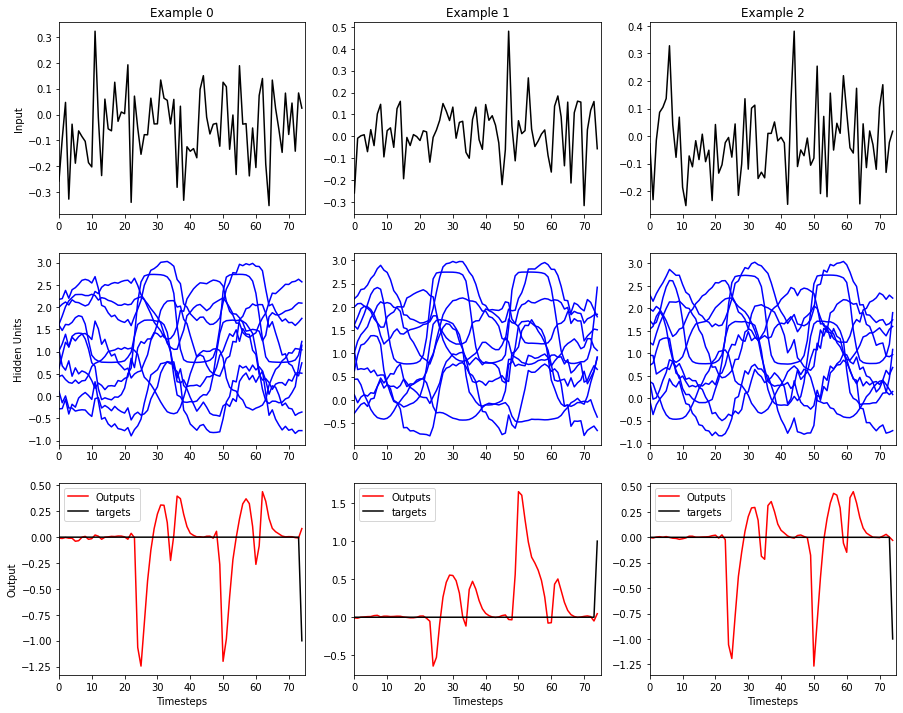

In [ ]:
plot_examples(ntimesteps, rnn_internals, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warni

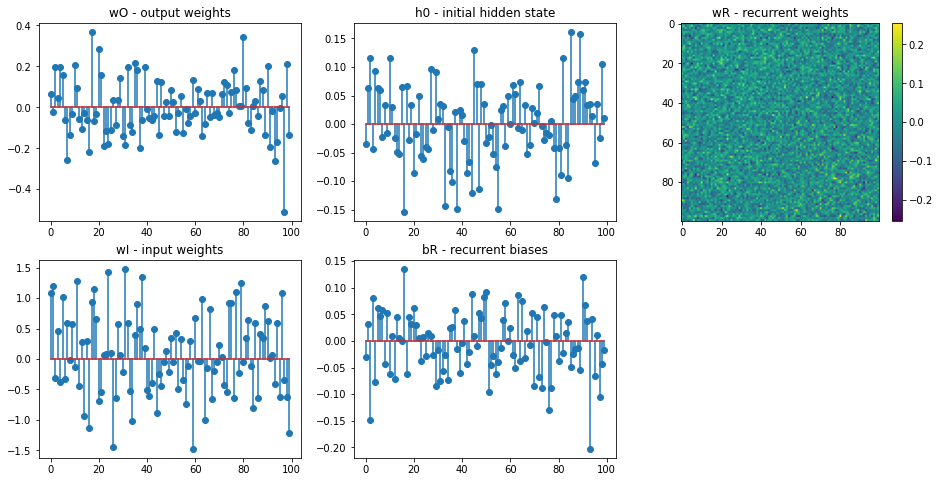

In [ ]:
# Take a look at the trained parameters.
plot_params(params)